# Information Retrival Project

Authors: Delia Mennitti - 19610, Letizia Meroi - 19041, Sara Napolitano - 24656 

# Introduction

This project investigates the effectiveness of **dense retrieval methods** compared to traditional **sparse retrieval** (BM25) for multilingual and cross-lingual information retrieval tasks. 

We implement and evaluate:
1. **BM25** as a lexical baseline
2. **LaBSE** (Language-agnostic BERT Sentence Embedding) for dense semantic retrieval
3. **Hybrid**  

# Dataset and Task Description

For this project, we use the **SWIM-IR dataset**, which is described in detail in the paper *"Leveraging LLMs for Synthesizing Training Data Across Many Languages in Multilingual Dense Retrieval"* by Nandan Thakur, Jianmo Ni, Gustavo Hernández Ábrego, John Wieting, Jimmy Lin, and Daniel Cer.

We focus on a **cross-lingual Information Retrieval (IR) task** using the SWIM-IR dataset.

Given an English query, the objective is to **retrieve the relevant Wikipedia passage written in another language**. Each query has exactly one associated relevant passage, enabling **automatic and reproducible evaluation** of retrieval performance.

The dataset contains three main splits:
- **monolingual**: Query and document in the same language
- **cross_lingual**: Query in English, document in another language (17 languages)
- **cross_lingual_ext**: Extended cross-lingual split focusing on Indic languages (16 languages)

This setup allows us to evaluate both monolingual and cross-lingual retrieval capabilities of different methods.

We selected a diverse set of 5 languages representing different language families:
- **German (de)**: Germanic language family
- **French (fr)**: Romance language family
- **Spanish (es)**: Romance language family
- **English (en)**: Germanic language family
- **Chinese (zh)**: Sino-Tibetan language family

This selection provides coverage across both European languages and non-alphabetic writing systems.

In [1]:
import os
import json
import gzip
from collections import defaultdict
import numpy as np
import pandas as pd
from tqdm import tqdm
import ast
from rank_bm25 import BM25Okapi
import jieba
import matplotlib.pyplot as plt
import seaborn as sns
import gc

c:\Users\saran\anaconda3\envs\clean\Lib\site-packages\jieba\_compat.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Base data directory
BASE_DATA_DIR = "data/swim_ir_v1/swim_ir_v1"

# Exploratory Data Analysis

Before implementing our retrieval methods, we analyze the SWIM-IR dataset to understand its key characteristics: structure, scale, and text properties.

SWIM-IR DATASET OVERVIEW

Splits: 3 (cross_lingual, cross_lingual_ext, monolingual)
Total languages: 33
Total query-document pairs: 18,699,888

By split:
  cross_lingual: 17 languages, 15,439,922 pairs
  cross_lingual_ext: 16 languages, 92,954 pairs
  monolingual: 10 languages, 3,167,012 pairs


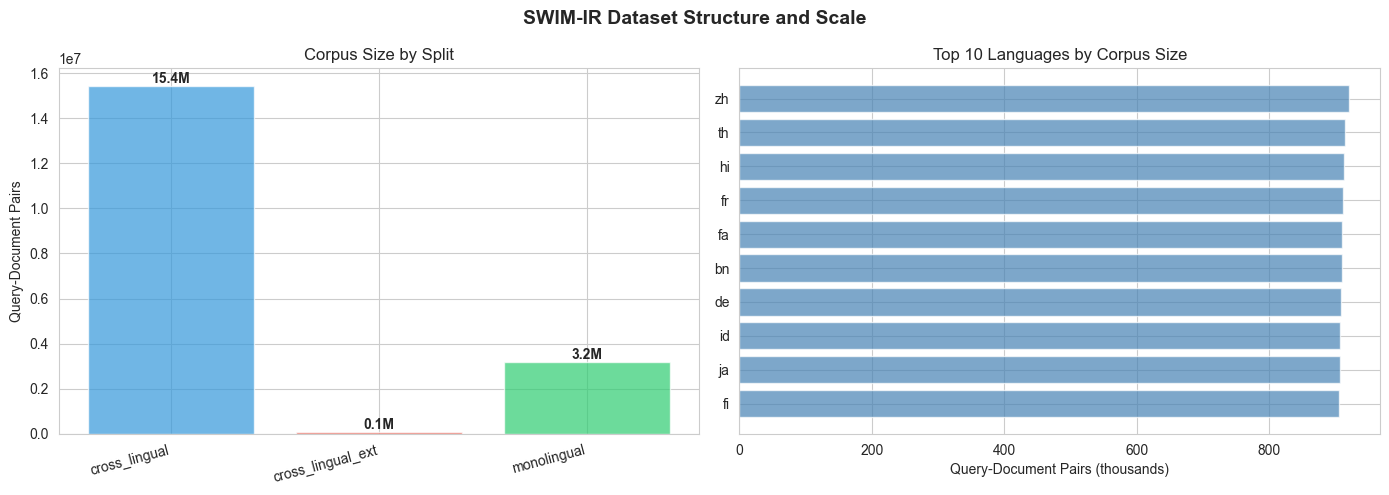

In [3]:
# Dataset overview and corpus statistics
sns.set_style("whitegrid")

# Get structure and count corpus sizes
dataset_structure = {}
corpus_sizes = []

for split in os.listdir(BASE_DATA_DIR):
    split_path = os.path.join(BASE_DATA_DIR, split)
    if os.path.isdir(split_path) and not split.startswith('.'):
        languages = [d for d in os.listdir(split_path) 
                    if os.path.isdir(os.path.join(split_path, d)) and not d.startswith('.')]
        dataset_structure[split] = sorted(languages)
        
        # Count items per language
        for lang in languages:
            lang_path = os.path.join(split_path, lang, "train.jsonl")
            if os.path.isfile(lang_path):
                with open(lang_path, 'r', encoding='utf-8') as f:
                    count = sum(1 for _ in f)
                corpus_sizes.append({'split': split, 'language': lang, 'num_items': count})

df_sizes = pd.DataFrame(corpus_sizes)

print("="*70)
print("SWIM-IR DATASET OVERVIEW")
print("="*70)
print(f"\nSplits: {len(dataset_structure)} ({', '.join(dataset_structure.keys())})")
print(f"Total languages: {len(set([l for ls in dataset_structure.values() for l in ls]))}")
print(f"Total query-document pairs: {df_sizes['num_items'].sum():,}")
print(f"\nBy split:")
for split in dataset_structure:
    split_total = df_sizes[df_sizes['split']==split]['num_items'].sum()
    print(f"  {split}: {len(dataset_structure[split])} languages, {split_total:,} pairs")

# Compact visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('SWIM-IR Dataset Structure and Scale', fontsize=14, fontweight='bold')

# Split distribution
ax1 = axes[0]
split_totals = df_sizes.groupby('split')['num_items'].sum()
ax1.bar(range(len(split_totals)), split_totals.values, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7)
ax1.set_xticks(range(len(split_totals)))
ax1.set_xticklabels(split_totals.index, rotation=15, ha='right')
ax1.set_ylabel('Query-Document Pairs')
ax1.set_title('Corpus Size by Split')
for i, v in enumerate(split_totals.values):
    ax1.text(i, v, f'{v/1e6:.1f}M', ha='center', va='bottom', fontweight='bold')

# Top languages
ax2 = axes[1]
top_10 = df_sizes.nlargest(10, 'num_items')
ax2.barh(range(len(top_10)), top_10['num_items']/1000, color='steelblue', alpha=0.7)
ax2.set_yticks(range(len(top_10)))
ax2.set_yticklabels([f"{r['language']}" for _, r in top_10.iterrows()])
ax2.set_xlabel('Query-Document Pairs (thousands)')
ax2.set_title('Top 10 Languages by Corpus Size')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

TEXT LENGTH CHARACTERISTICS

Documents: ~97 words
Queries: ~8 words
Titles: ~2 words

Documents are ~11.9x longer than queries


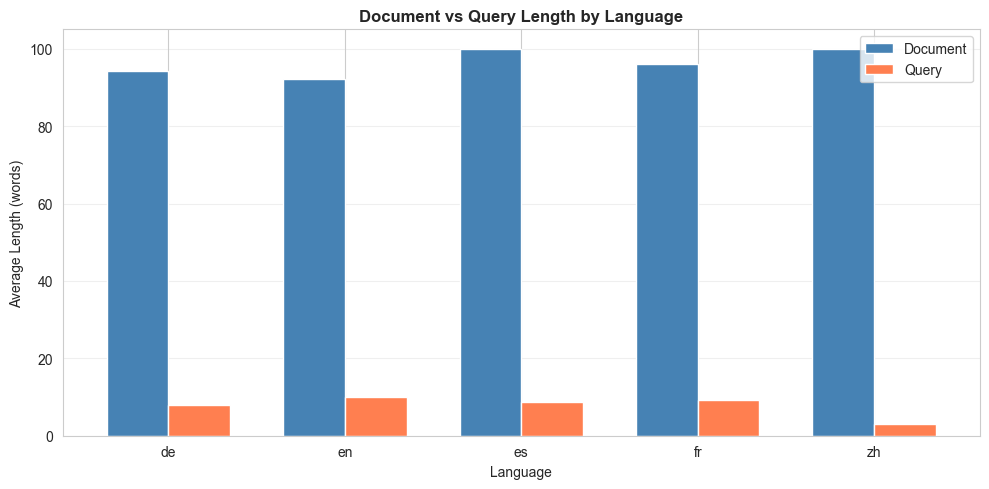

In [4]:
# Text length analysis
SAMPLE_SIZE = 500
SELECTED_LANGUAGES_EDA = ['de', 'fr', 'es', 'en', 'zh']
CORPUS_SPLITS = [d for d in os.listdir(BASE_DATA_DIR) if os.path.isdir(os.path.join(BASE_DATA_DIR, d))]

text_stats = []
for split in CORPUS_SPLITS:
    split_path = os.path.join(BASE_DATA_DIR, split)
    if not os.path.exists(split_path):
        continue
        
    for lang in SELECTED_LANGUAGES_EDA:
        lang_path = os.path.join(split_path, lang, "train.jsonl")
        if not os.path.isfile(lang_path):
            continue
            
        doc_lengths, query_lengths, title_lengths = [], [], []
        with open(lang_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if i >= SAMPLE_SIZE:
                    break
                try:
                    item = ast.literal_eval(line.strip())
                    doc_lengths.append(len(item.get('text', '').split()))
                    query_lengths.append(len(item.get('query', '').split()))
                    title_lengths.append(len(item.get('title', '').split()))
                except:
                    continue
        
        if doc_lengths:
            text_stats.append({
                'split': split, 'language': lang,
                'avg_doc': np.mean(doc_lengths),
                'avg_query': np.mean(query_lengths),
                'avg_title': np.mean(title_lengths)
            })

df_text = pd.DataFrame(text_stats)

if len(df_text) > 0:
    print("="*70)
    print("TEXT LENGTH CHARACTERISTICS")
    print("="*70)
    print(f"\nDocuments: ~{df_text['avg_doc'].mean():.0f} words")
    print(f"Queries: ~{df_text['avg_query'].mean():.0f} words")
    print(f"Titles: ~{df_text['avg_title'].mean():.0f} words")
    print(f"\nDocuments are ~{df_text['avg_doc'].mean() / df_text['avg_query'].mean():.1f}x longer than queries")
    
    # Single compact visualization
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    comparison = df_text.groupby('language')[['avg_doc', 'avg_query']].mean()
    comparison.plot(kind='bar', ax=ax, color=['steelblue', 'coral'], width=0.7)
    ax.set_ylabel('Average Length (words)')
    ax.set_xlabel('Language')
    ax.set_title('Document vs Query Length by Language', fontweight='bold')
    ax.legend(['Document', 'Query'])
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Methodology

### Evaluation Metrics
We evaluate all retrieval methods using two standard information retrieval metrics computed at rank $K=10$:
- **Recall@10**: The fraction of queries for which the relevant document appears in the top-10 ranked results. This metric measures the system's ability to retrieve relevant documents without requiring them to be ranked first.
  
  $$\text{Recall@10} = \frac{\text{nr queries with relevant doc in top-10}}{\text{Total nr queries}}$$

- **MRR@10 (Mean Reciprocal Rank)**: The average reciprocal rank of the first relevant document for all queries, capped at rank 10. This metric rewards methods that rank relevant documents higher in the result list.
  
  $$\text{MRR@10} = \frac{1}{|Q|} \sum_{q=1}^{|Q|} \frac{1}{\text{rank}_q}$$
  
  where $\text{rank}_q$ is the position of the relevant document for query $q$ (or 0 if not in top-10).

Both metrics range from 0 to 1, with higher values indicating better performance.

### Retrieval Methods Compared
We compare three retrieval approaches:
1. **BM25 (Sparse Lexical Retrieval)**: A baseline probabilistic ranking function based on term frequency and inverse document frequency weighting.
2. **LaBSE (Dense Semantic Retrieval)**: A multilingual BERT-based embedding model that captures semantic similarity across languages without explicit fine-tuning.
3. **Hybrid (Score-based Fusion)**: A weighted combination of BM25 and LaBSE scores, with the weight parameter $\alpha$ tuned on a validation set to maximize performance.

For each method, we retrieve the top 10 documents per query and evaluate against the ground-truth relevant document.

# 1. Baseline: BM25 (Sparse Lexical Retrieval)

We implement **BM25 (Best Matching 25)**, a probabilistic ranking function based on the bag-of-words representation. BM25 is one of the most widely used sparse retrieval methods in information retrieval.

**Key characteristics:**
- Uses term frequency (TF) and inverse document frequency (IDF) weighting
- Language-specific tokenization (including jieba for Chinese)
- No semantic understanding - relies purely on lexical overlap
- Fast and efficient for large-scale retrieval

BM25 serves as our baseline to evaluate the effectiveness of dense retrieval methods.

In [5]:
def encode_texts(texts, batch_size=1):
    """Encode texts to embeddings.
    EXTREMELY CONSERVATIVE: batch_size=1 (process one at a time)
    """
    if not globals().get('RUN_DENSE', False):
        raise RuntimeError('Dense encoding was disabled (RUN_DENSE=False)')
    
    if not texts:
        raise ValueError('No texts provided for encoding')
    
    try:
        print(f"  Encoding {len(texts)} texts with batch_size={batch_size}...")
        embeddings = model.encode(
            texts,
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=True  # important for cosine similarity
        )
        # Force garbage collection after encoding
        gc.collect()
        return embeddings
    except MemoryError as me:
        print(f'[ERROR] MemoryError during encoding: {me}')
        print('[TIP] Memory exhausted - try disabling RUN_DENSE or reducing MAX_ITEMS to 2')
        gc.collect()
        raise
    except Exception as e:
        print(f'[ERROR] Error during encoding: {e}')
        gc.collect()
        raise

In [6]:
# Global cache for scores
SCORE_CACHE = {}  # key: (split, lang) -> dict with bm25_scores, dense_scores, doc_ids, query_ids, qrels

# Run BM25 for each language folder under each split (cross_lingual, monolingual, etc.)
CORPUS_SPLITS = [d for d in os.listdir(BASE_DATA_DIR) if os.path.isdir(os.path.join(BASE_DATA_DIR, d))]

# Fixed set of languages to process (Italian not available in dataset)
SELECTED_LANGUAGES = ['de', 'fr', 'es', 'en', 'zh']  # German, French, Spanish, English, Chinese

# Start with 5 items - sklearn is more stable than FAISS
MAX_ITEMS = 1000 
K = 10  # top-K retrieval
CANDIDATE_N = 500  # candidates from BM25 and Dense (>= K)

# Robust JSONL loader
def load_jsonl_robust(path, max_items=1000):
    data = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_items and i >= max_items:
                break
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
            except json.JSONDecodeError:
                obj = ast.literal_eval(line)
            data.append(obj)
    return data

# Tokenizer
def tokenize(text, lang_code):
    if lang_code == "zh":
        return list(jieba.cut(text))
    else:
        return text.lower().split()

# Evaluation
def evaluate(retrieved, qrels, K=10):
    recalls = []
    rr_list = []
    for qid, top_docs in retrieved.items():
        relevant_doc = qrels[qid]
        recalls.append(1.0 if relevant_doc in top_docs[:K] else 0.0)
        try:
            rank = top_docs.index(relevant_doc) + 1
            rr_list.append(1.0 / rank)
        except ValueError:
            rr_list.append(0.0)
    return np.mean(recalls), np.mean(rr_list)

# Store results
results = []

print(f"Processing selected languages: {', '.join(SELECTED_LANGUAGES)}\n")

Processing selected languages: de, fr, es, en, zh



In [7]:
BM25_CACHE_DIR = "artifacts_cache_bm25"
os.makedirs(BM25_CACHE_DIR, exist_ok=True)

def bm25_cache_path(split, lang, max_items, k, topn):
    return os.path.join(BM25_CACHE_DIR, f"{split}__{lang}__max{max_items}__k{k}__topn{topn}.json")

def load_bm25_from_disk(split, lang, max_items=MAX_ITEMS, k=K, topn=None):
    if topn is None:
        topn = max(CANDIDATE_N, K)
    path = bm25_cache_path(split, lang, max_items, k, topn)
    if not os.path.exists(path):
        return None
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def save_bm25_to_disk(split, lang, payload, max_items=MAX_ITEMS, k=K, topn=None):
    if topn is None:
        topn = payload.get("TOPN", max(CANDIDATE_N, K))
    path = bm25_cache_path(split, lang, max_items, k, topn)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(payload, f)



In [8]:
# put true only if you really need the QxD BM25 matrix
STORE_BM25_MATRIX = False  


In [9]:
for split in CORPUS_SPLITS:
    split_path = os.path.join(BASE_DATA_DIR, split)
    
    for lang_code in os.listdir(split_path):
        # Only process selected languages
        if lang_code not in SELECTED_LANGUAGES:
            continue
            
        lang_dir = os.path.join(split_path, lang_code)
        lang_path = os.path.join(lang_dir, "train.jsonl")
        if not os.path.isfile(lang_path):
            continue
            
        print(f"\n{'='*60}")
        print(f"Processing {split}/{lang_code}")
        print('='*60)

        TOPN = max(CANDIDATE_N, K)
        cached = load_bm25_from_disk(split, lang_code, MAX_ITEMS, K, TOPN)

        if cached is not None:
            print("BM25 cache hit – loading top-K from disk (skip BM25 computation)")

            # put in RAM cache for later hybrid/rerank
            SCORE_CACHE[(split, lang_code)] = SCORE_CACHE.get((split, lang_code), {})
            SCORE_CACHE[(split, lang_code)].update(cached)

            # Recompute metrics quickly from cached top-K
            recall, mrr = evaluate(cached["bm25_topk_docs"], cached["qrels"], K=K)
            results.append({
                "split": split,
                "language": lang_code,
                "Recall@10": recall,
                "MRR@10": mrr,
                "method": "BM25"
            })
            continue

        data = load_jsonl_robust(lang_path, max_items=MAX_ITEMS)

        # Build documents, queries, qrels
        documents = {}
        queries = {}
        qrels = {}
        for item in data:
            doc_id = f"{lang_code}_{item['_id']}"
            lang_field = item.get("code", lang_code)
            documents[doc_id] = {"text": item.get("title", "") + " " + item.get("text", ""), "lang": lang_field}
            queries[doc_id] = item.get("query", "")
            qrels[doc_id] = doc_id

        # Tokenize corpus
        doc_ids = list(documents.keys())
        query_ids = list(queries.keys())

        tokenized_corpus = [tokenize(documents[doc_id]["text"], documents[doc_id]["lang"]) for doc_id in doc_ids]

        if len(tokenized_corpus) == 0:
            print("No documents found, skipping.")
            continue

        bm25 = BM25Okapi(tokenized_corpus)

        # Tokenize queries
        tokenized_queries = {qid: tokenize(q, documents[qid]["lang"]) for qid, q in queries.items()}

        # Optional: Build BM25 score matrix QxD
        Q = len(query_ids)
        D = len(doc_ids)
        bm25_scores_matrix = None
        if STORE_BM25_MATRIX:
            bm25_scores_matrix = np.zeros((Q, D), dtype=np.float32)

        # Retrieve top-K
        bm25_topk_docs = {}
        bm25_topk_scores = {}
        retrieved = {}
        TOPN = max(CANDIDATE_N, K)
        for i, qid in enumerate(query_ids):
            scores = np.asarray(bm25.get_scores(tokenized_queries[qid]), dtype=np.float32)
            if STORE_BM25_MATRIX:
                bm25_scores_matrix[i, :] = scores

            top_indices = scores.argsort()[-TOPN:][::-1]
            docs = [doc_ids[j] for j in top_indices]
            scs  = [float(scores[j]) for j in top_indices]

            retrieved[qid] = docs
            bm25_topk_docs[qid] = docs
            bm25_topk_scores[qid] = scs

        # Evaluate
        recall, mrr = evaluate(retrieved, qrels, K=K)
        results.append({"split": split, "language": lang_code, "Recall@10": recall, "MRR@10": mrr, "method": "BM25"})
        print(f"[OK] BM25 - Recall@{K}: {recall:.4f}, MRR@{K}: {mrr:.4f}")
        
        # Save to cache
        key = (split, lang_code)
        SCORE_CACHE[key] = SCORE_CACHE.get(key, {})
        update_pack = {
            "bm25_topk_docs": bm25_topk_docs,
            "bm25_topk_scores": bm25_topk_scores,
            "doc_ids": doc_ids,
            "query_ids": query_ids,
            "qrels": qrels
        }
        if STORE_BM25_MATRIX:
            update_pack["bm25"] = bm25_scores_matrix

        SCORE_CACHE[key].update(update_pack)


        # Save only BM25 top-K to disk, matrix is large and remains in RAM
        payload = {
            "doc_ids": doc_ids,
            "query_ids": query_ids,
            "qrels": qrels,
            "bm25_topk_docs": bm25_topk_docs,
            "bm25_topk_scores": bm25_topk_scores,
            "TOPN": int(TOPN)
        }
        save_bm25_to_disk(split, lang_code, payload, MAX_ITEMS, K, TOPN)
        print("BM25 top-K cached to disk.")
        gc.collect()

# Display summary table
print("\n" + "="*60)
print("SUMMARY RESULTS")
print("="*60)
df_results = pd.DataFrame(results)
print(f"\nTotal experiments: {len(df_results)}")


df_results


Processing cross_lingual/de
BM25 cache hit – loading top-K from disk (skip BM25 computation)

Processing cross_lingual/es
BM25 cache hit – loading top-K from disk (skip BM25 computation)

Processing cross_lingual/fr
BM25 cache hit – loading top-K from disk (skip BM25 computation)

Processing cross_lingual/zh
BM25 cache hit – loading top-K from disk (skip BM25 computation)

Processing monolingual/de
BM25 cache hit – loading top-K from disk (skip BM25 computation)

Processing monolingual/en
BM25 cache hit – loading top-K from disk (skip BM25 computation)

Processing monolingual/es
BM25 cache hit – loading top-K from disk (skip BM25 computation)

Processing monolingual/fr
BM25 cache hit – loading top-K from disk (skip BM25 computation)

SUMMARY RESULTS

Total experiments: 8


,split,language,Recall@10,MRR@10,method
0,cross_lingual,de,0.573,0.468284,BM25
1,cross_lingual,es,0.423,0.300049,BM25
2,cross_lingual,fr,0.577,0.449085,BM25
3,cross_lingual,zh,0.614,0.531713,BM25
4,monolingual,de,0.817,0.757765,BM25
5,monolingual,en,0.939,0.881412,BM25
6,monolingual,es,0.797,0.705987,BM25
7,monolingual,fr,0.609,0.507563,BM25


# 2. Dense Retrieval Using Multilingual Embeddings

## Approach

We implement a **dense retrieval system** using deep learning-based text embeddings. Unlike sparse methods like BM25, dense retrieval represents texts as continuous vectors in a high-dimensional space, enabling semantic similarity matching.

## Model Selection: LaBSE

We use **LaBSE** (Language-agnostic BERT Sentence Embedding) from the sentence-transformers library, which offers:

- **Multilingual support**: Pre-trained on 109 languages
- **Cross-lingual alignment**: Semantically similar texts in different languages map to nearby vectors
- **768-dimensional embeddings**: Rich semantic representations
- **Zero-shot capability**: No fine-tuning required for new language pairs

## Implementation Details

For similarity computation, we use **sklearn's cosine_similarity** instead of FAISS. This approach proved more stable and memory-efficient for our dataset size (1000 items per language), avoiding kernel crashes experienced with FAISS on M3 Mac hardware (16GB RAM).

The retrieval process:
1. Encode all documents into 768-dim vectors
2. Encode all queries into 768-dim vectors  
3. Compute cosine similarity matrix (queries × documents)
4. Rank documents by similarity scores
5. Retrieve top-K results for evaluation

## Alternative Models Considered

Several multilingual embedding models were systematically evaluated for suitability in cross-lingual information retrieval. LaBSE emerged as the preferred choice due to its strong cross-lingual alignment and consistent zero-shot performance across languages, eliminating the need for task-specific fine-tuning. While mSBERT offered advantages in terms of speed and reduced model size, its cross-lingual representations were comparatively weaker, making it less reliable for retrieval accuracy. A fine-tuned XLM-R model was also considered because of its flexibility; however, it requires additional pooling strategies and careful tuning to perform effectively for information retrieval tasks. Overall, LaBSE provided the best balance of performance and operational simplicity for the project’s multilingual requirements.


In [10]:
# Dense retrieval: Using sklearn instead of FAISS (more stable)
RUN_DENSE = True  # set to False to skip dense retrieval

if RUN_DENSE:
    try:
        from sentence_transformers import SentenceTransformer
        from sklearn.metrics.pairwise import cosine_similarity
        import numpy as np
        model = SentenceTransformer("sentence-transformers/LaBSE")
        print('[OK] LaBSE model loaded')
        print('[OK] Using sklearn cosine_similarity (more stable than FAISS)')
    except Exception as e:
        print('Failed to load dense model:', e)
        RUN_DENSE = False
else:
    print('Dense retrieval disabled (RUN_DENSE=False)')

c:\Users\saran\anaconda3\envs\clean\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[OK] LaBSE model loaded
[OK] Using sklearn cosine_similarity (more stable than FAISS)


In [11]:
import os, json, tempfile

DENSE_CACHE_DIR = "artifacts_cache_dense"
os.makedirs(DENSE_CACHE_DIR, exist_ok=True)

def dense_cache_path(split, lang):
    return os.path.join(DENSE_CACHE_DIR, f"{split}__{lang}__max{MAX_ITEMS}__k{K}.json")

def load_dense_from_disk(split, lang):
    path = dense_cache_path(split, lang)
    if not os.path.exists(path):
        return None
    try:
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)
    except json.JSONDecodeError:
        # Corrupted file - rename to .bad and treat as cache miss
        bad = path + ".bad"
        try:
            os.replace(path, bad)
        except Exception:
            pass
        print(f"[WARN] Dense cache corrupt -> renamed to {bad}. Recompute...")
        return None

def save_dense_to_disk(split, lang, payload):
    os.makedirs(DENSE_CACHE_DIR, exist_ok=True)
    path = dense_cache_path(split, lang)

    # Atomic write, avoid partial files
    fd, tmp_path = tempfile.mkstemp(dir=DENSE_CACHE_DIR, suffix=".tmp")
    try:
        with os.fdopen(fd, "w", encoding="utf-8") as f:
            json.dump(payload, f)
            f.flush()
            os.fsync(f.fileno())
        os.replace(tmp_path, path)
    finally:
        if os.path.exists(tmp_path):
            try:
                os.remove(tmp_path)
            except Exception:
                pass


In [12]:
for split in CORPUS_SPLITS:
    split_path = os.path.join(BASE_DATA_DIR, split)
    
    for lang_code in os.listdir(split_path):
        # Only process selected languages
        if lang_code not in SELECTED_LANGUAGES:
            continue

        print(f"\n{'='*60}")
        print(f"Processing {split}/{lang_code}")
        print('='*60)

        # Check cache
        cached_dense = load_dense_from_disk(split, lang_code)
        if cached_dense is not None:
            print("Dense cache hit – loading precomputed top-N...")

            key = (split, lang_code)
            SCORE_CACHE[key] = SCORE_CACHE.get(key, {})
            SCORE_CACHE[key].update(cached_dense)
            
            # Evaluate cached results
            recall, mrr = evaluate(cached_dense["dense_topk_docs"], cached_dense["qrels"], K=K)
            results.append({
                "split": split,
                "language": lang_code,
                "Recall@10": recall,
                "MRR@10": mrr,
                "method": "LaBSE"
            })
            print(f"[OK] LaBSE - Recall@{K}: {recall:.4f}, MRR@{K}: {mrr:.4f}")
            continue

        print("Cache miss – computing scores...")

        lang_dir = os.path.join(split_path, lang_code)
        lang_path = os.path.join(lang_dir, "train.jsonl")
        if not os.path.isfile(lang_path):
            continue
            
        
        data = load_jsonl_robust(lang_path, max_items=MAX_ITEMS)

        # Build documents, queries, qrels
        documents = {}
        queries = {}
        qrels = {}
        for item in data:
            doc_id = f"{lang_code}_{item['_id']}"
            lang_field = item.get("code", lang_code)
            documents[doc_id] = {"text": item.get("title", "") + " " + item.get("text", ""), "lang": lang_field}
            queries[doc_id] = item.get("query", "")
            qrels[doc_id] = doc_id

        
        doc_ids = list(documents.keys())
        query_ids = list(queries.keys())


        # Dense retrieval for this language using sklearn (no FAISS!)
        if globals().get('RUN_DENSE', False):
            try:
                # Encode documents
                doc_texts = [documents[doc_id]["text"] for doc_id in doc_ids]
                print(f"\n[DENSE] Encoding {len(doc_texts)} documents...")
                doc_embeddings = encode_texts(doc_texts)
                print(f"[OK] Document embeddings shape: {doc_embeddings.shape}")

                # Encode queries
                query_id = list(queries.keys())
                query_texts = [queries[qid] for qid in query_ids]
                print(f"\n[DENSE] Encoding {len(query_texts)} queries...")
                query_embeddings = encode_texts(query_texts)
                print(f"[OK] Query embeddings shape: {query_embeddings.shape}")

                # Use sklearn cosine_similarity instead of FAISS
                print(f"\n[DENSE] Computing cosine similarities...")
                # Compute similarity matrix: queries x documents
                similarities = cosine_similarity(query_embeddings, doc_embeddings)
                print(f"[OK] Similarity matrix shape: {similarities.shape}")
                
                # Get top-K for each query
                dense_topk_docs = {}
                dense_topk_scores = {}
                TOPN = max(CANDIDATE_N, K)
                for i, qid in enumerate(query_ids):
                    # Get similarities for this query
                    query_sims = similarities[i]
                    # Get top-K indices
                    top_indices = query_sims.argsort()[-TOPN:][::-1]

                    docs = [doc_ids[idx] for idx in top_indices]
                    scores = [float(query_sims[idx]) for idx in top_indices]

                    dense_topk_docs[qid] = docs
                    dense_topk_scores[qid] = scores
                    print(f"  Query {i+1}/{len(query_ids)}: done")

                # Evaluate
                recall, mrr = evaluate(dense_topk_docs, qrels, K=K)
                results.append({
                    "split": split,
                    "language": lang_code,
                    "Recall@10": recall,
                    "MRR@10": mrr,
                    "method": "LaBSE"
                })
                print(f"\n[OK] LaBSE - Recall@{K}: {recall:.4f}, MRR@{K}: {mrr:.4f}")
                
                # Save dense matrix to cache
                dense_payload = {
                    "doc_ids": doc_ids,
                    "query_ids": query_ids,
                    "qrels": qrels,
                    "dense_topk_docs": dense_topk_docs,
                    "dense_topk_scores": dense_topk_scores,
                    "TOPN": int(TOPN)
                }

                key = (split, lang_code)
                SCORE_CACHE[key] = SCORE_CACHE.get(key, {})
                SCORE_CACHE[key].update(dense_payload)

                save_dense_to_disk(split, lang_code, dense_payload)
                print("Dense top-N cached to disk.")



                # Clean up
                del doc_embeddings, query_embeddings, similarities
                gc.collect()
                
            except Exception as e:
                print(f"\n[ERROR] Dense retrieval failed for {split}/{lang_code}: {e}")
                print("Continuing with next language...")
                import traceback
                traceback.print_exc()
                gc.collect()
        
        gc.collect()

# Display summary table
print("\n" + "="*60)
print("SUMMARY RESULTS")
print("="*60)
df_results = pd.DataFrame(results)
print(f"\nTotal experiments: {len(df_results)}")


print(f"\n[OK] Using sklearn cosine_similarity - much more stable!")
print(f"If stable, increase MAX_ITEMS: 5 -> 10 -> 25 -> 50 -> 100")

df_results


Processing cross_lingual/de
Dense cache hit – loading precomputed top-N...
[OK] LaBSE - Recall@10: 0.8520, MRR@10: 0.6841

Processing cross_lingual/es
Dense cache hit – loading precomputed top-N...
[OK] LaBSE - Recall@10: 0.8530, MRR@10: 0.6780

Processing cross_lingual/fr
Dense cache hit – loading precomputed top-N...
[OK] LaBSE - Recall@10: 0.7940, MRR@10: 0.6262

Processing cross_lingual/zh
Dense cache hit – loading precomputed top-N...
[OK] LaBSE - Recall@10: 0.8540, MRR@10: 0.6793

Processing monolingual/de
Dense cache hit – loading precomputed top-N...
[OK] LaBSE - Recall@10: 0.8880, MRR@10: 0.7990

Processing monolingual/en
Dense cache hit – loading precomputed top-N...
[OK] LaBSE - Recall@10: 0.9300, MRR@10: 0.8462

Processing monolingual/es
Dense cache hit – loading precomputed top-N...
[OK] LaBSE - Recall@10: 0.8610, MRR@10: 0.7336

Processing monolingual/fr
Dense cache hit – loading precomputed top-N...
[OK] LaBSE - Recall@10: 0.7610, MRR@10: 0.6156

SUMMARY RESULTS

Total 

,split,language,Recall@10,MRR@10,method
0,cross_lingual,de,0.573,0.468284,BM25
1,cross_lingual,es,0.423,0.300049,BM25
2,cross_lingual,fr,0.577,0.449085,BM25
3,cross_lingual,zh,0.614,0.531713,BM25
4,monolingual,de,0.817,0.757765,BM25
5,monolingual,en,0.939,0.881412,BM25
6,monolingual,es,0.797,0.705987,BM25
7,monolingual,fr,0.609,0.507563,BM25
8,cross_lingual,de,0.852,0.684115,LaBSE
9,cross_lingual,es,0.853,0.678010,LaBSE


In [13]:
import copy
import time

# copy and freeze results and use them later
results_frozen = copy.deepcopy(results)
df_results_frozen = df_results.copy(deep=True)

# save frozen results with timestamp
ts = time.strftime("%Y%m%d_%H%M%S")
df_results_frozen.to_pickle(f"df_results_frozen_{ts}.pkl")

print("Base results frozen and saved")

Base results frozen and saved


# Comparison between BM25 and LaBSE

DETAILED RESULTS COMPARISON: BM25 vs LaBSE (Dense BERT)

[RESULTS] All Results:
        split language  Recall@10   MRR@10 method
cross_lingual       de      0.573 0.468284   BM25
cross_lingual       es      0.423 0.300049   BM25
cross_lingual       fr      0.577 0.449085   BM25
cross_lingual       zh      0.614 0.531713   BM25
  monolingual       de      0.817 0.757765   BM25
  monolingual       en      0.939 0.881412   BM25
  monolingual       es      0.797 0.705987   BM25
  monolingual       fr      0.609 0.507563   BM25
cross_lingual       de      0.852 0.684115  LaBSE
cross_lingual       es      0.853 0.678010  LaBSE
cross_lingual       fr      0.794 0.626238  LaBSE
cross_lingual       zh      0.854 0.679336  LaBSE
  monolingual       de      0.888 0.798978  LaBSE
  monolingual       en      0.930 0.846210  LaBSE
  monolingual       es      0.861 0.733623  LaBSE
  monolingual       fr      0.761 0.615627  LaBSE

AVERAGE PERFORMANCE BY METHOD
        Recall@10    MRR@10
method     

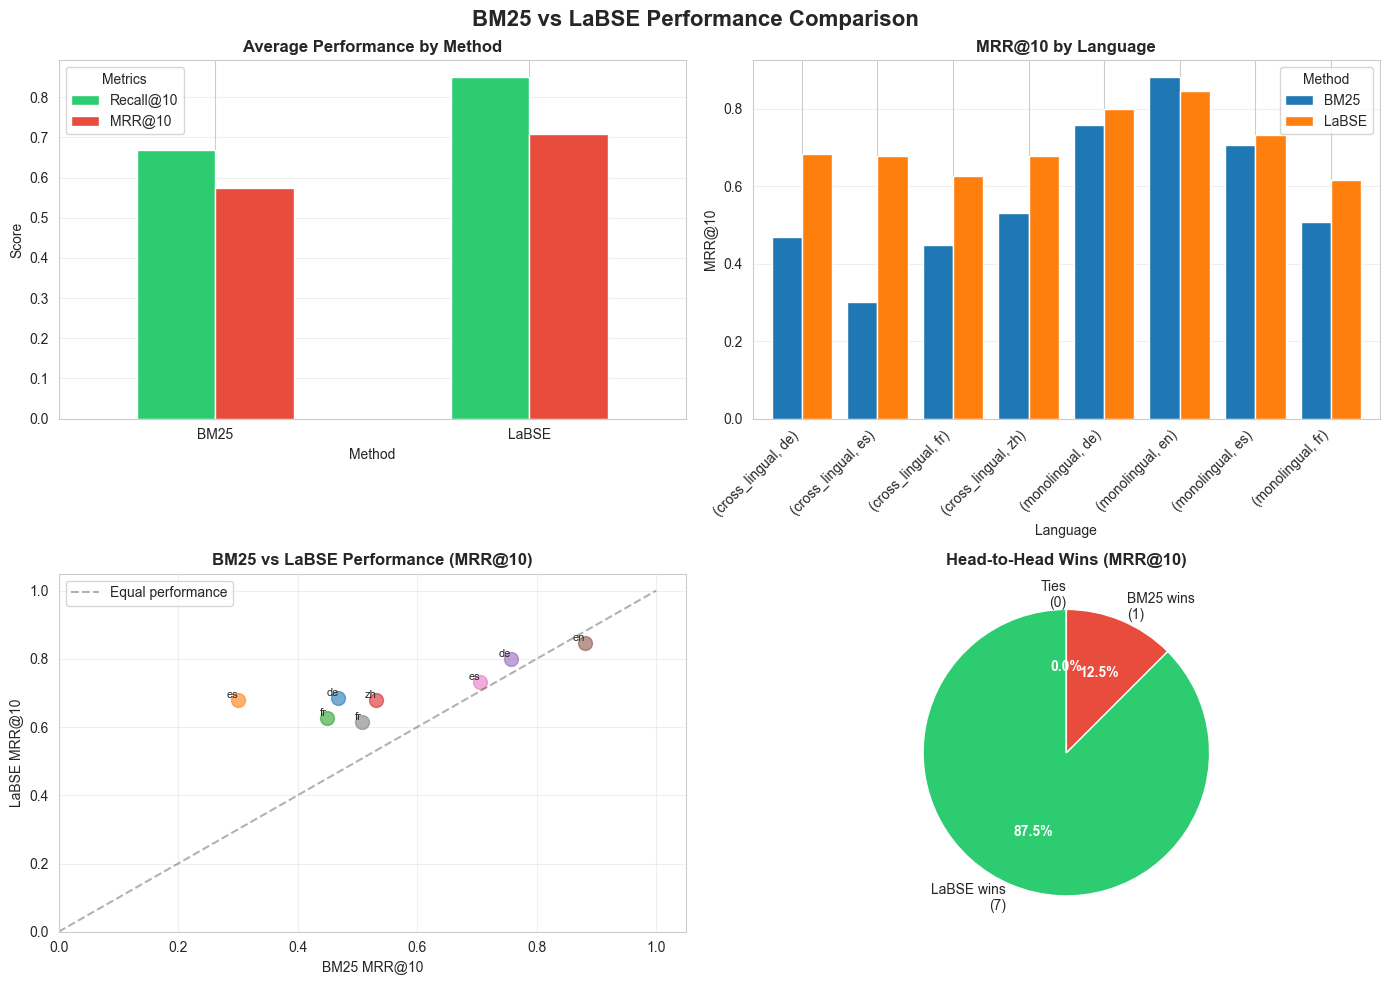

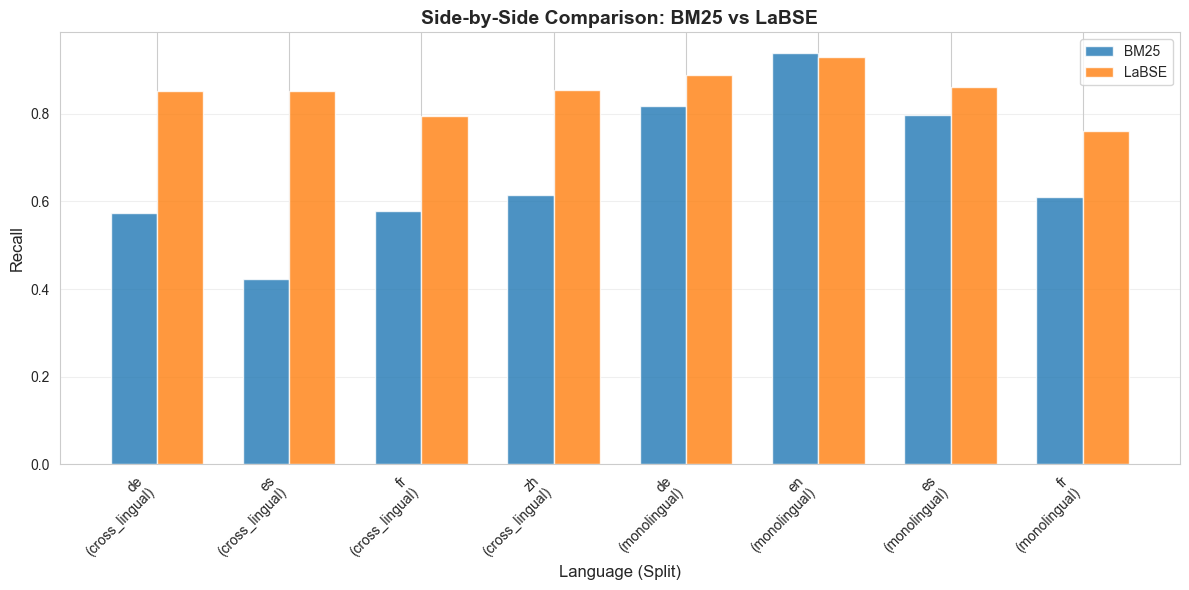

In [14]:
# Analyze and compare BM25 vs LaBSE (Dense BERT-based retrieval)
import matplotlib.pyplot as plt
import seaborn as sns

if 'df_results_frozen' in globals() and not df_results_frozen.empty:
    print("="*70)
    print("DETAILED RESULTS COMPARISON: BM25 vs LaBSE (Dense BERT)")
    print("="*70)
    
    # Show all results
    print("\n[RESULTS] All Results:")
    print(df_results_frozen.to_string(index=False))
    
    # Compare by method
    print("\n" + "="*70)
    print("AVERAGE PERFORMANCE BY METHOD")
    print("="*70)
    method_avg = df_results_frozen.groupby('method')[['Recall@10', 'MRR@10']].mean()
    print(method_avg)
    
    # Compare by language
    print("\n" + "="*70)
    print("PERFORMANCE BY LANGUAGE")
    print("="*70)
    
    # Pivot table for easier comparison
    pivot_recall = df_results_frozen.pivot_table(
        values='Recall@10', 
        index=['split', 'language'], 
        columns='method'
    ).fillna(0)
    
    pivot_mrr = df_results_frozen.pivot_table(
        values='MRR@10', 
        index=['split', 'language'], 
        columns='method'
    ).fillna(0)
    
    print("\n[METRICS] Recall@10 by Language:")
    print(pivot_recall)
    
    print("\n[METRICS] MRR@10 by Language:")
    print(pivot_mrr)
    
    # Count wins
    if 'LaBSE' in df_results_frozen['method'].values and 'BM25' in df_results_frozen['method'].values:
        print("\n" + "="*70)
        print("HEAD-TO-HEAD COMPARISON")
        print("="*70)
        
        # Compare on Recall@10
        better_recall = (pivot_recall['LaBSE'] > pivot_recall['BM25']).sum()
        worse_recall = (pivot_recall['LaBSE'] < pivot_recall['BM25']).sum()
        tie_recall = (pivot_recall['LaBSE'] == pivot_recall['BM25']).sum()
        
        print(f"\n[COMPARISON] Recall@10 comparison:")
        print(f"  LaBSE wins: {better_recall}")
        print(f"  BM25 wins: {worse_recall}")
        print(f"  Ties: {tie_recall}")
        
        # Compare on MRR@10
        better_mrr = (pivot_mrr['LaBSE'] > pivot_mrr['BM25']).sum()
        worse_mrr = (pivot_mrr['LaBSE'] < pivot_mrr['BM25']).sum()
        tie_mrr = (pivot_mrr['LaBSE'] == pivot_mrr['BM25']).sum()
        
        print(f"\n[COMPARISON] MRR@10 comparison:")
        print(f"  LaBSE wins: {better_mrr}")
        print(f"  BM25 wins: {worse_mrr}")
        print(f"  Ties: {tie_mrr}")
        
        print("\n[INFO] LaBSE uses BERT-based dense embeddings (768-dim vectors)")
        print("[INFO] sklearn cosine_similarity for retrieval (no FAISS)")
        
        # Visualization plots
        print("\n" + "="*70)
        print("VISUALIZATIONS")
        print("="*70)
        
        # Set style
        sns.set_style("whitegrid")
        
        # Create figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('BM25 vs LaBSE Performance Comparison', fontsize=16, fontweight='bold')
        
        # 1. Bar chart: Average metrics by method
        ax1 = axes[0, 0]
        method_avg.plot(kind='bar', ax=ax1, color=['#2ecc71', '#e74c3c'])
        ax1.set_title('Average Performance by Method', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Method')
        ax1.set_ylabel('Score')
        ax1.legend(title='Metrics')
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
        ax1.grid(axis='y', alpha=0.3)
        
        # 2. Grouped bar chart: MRR@10 by language
        ax2 = axes[0, 1]
        pivot_mrr.plot(kind='bar', ax=ax2, width=0.8)
        ax2.set_title('MRR@10 by Language', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Language')
        ax2.set_ylabel('MRR@10')
        ax2.legend(title='Method')
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
        ax2.grid(axis='y', alpha=0.3)
        
        # 3. Scatter plot: BM25 vs LaBSE (Recall)
        ax3 = axes[1, 0]
        for idx, row in pivot_mrr.iterrows():
            split, lang = idx if isinstance(idx, tuple) else (idx, idx)
            ax3.scatter(row['BM25'], row['LaBSE'], s=100, alpha=0.6)
            ax3.annotate(lang, (row['BM25'], row['LaBSE']), 
                        fontsize=8, ha='right', va='bottom')
        
        # Add diagonal line
        max_val = max(pivot_mrr.max().max(), 1.0)
        ax3.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='Equal performance')
        ax3.set_xlim(0, max_val * 1.05)
        ax3.set_ylim(0, max_val * 1.05)
        ax3.set_xlabel('BM25 MRR@10')
        ax3.set_ylabel('LaBSE MRR@10')
        ax3.set_title('BM25 vs LaBSE Performance (MRR@10)', fontsize=12, fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Win/Loss pie chart
        ax4 = axes[1, 1]
        win_data = [better_mrr, worse_mrr, tie_mrr]
        labels = [f'LaBSE wins\n({better_mrr})', f'BM25 wins\n({worse_mrr})', f'Ties\n({tie_mrr})']
        colors = ['#2ecc71', '#e74c3c', '#95a5a6']
        wedges, texts, autotexts = ax4.pie(win_data, labels=labels, colors=colors, 
                                             autopct='%1.1f%%', startangle=90)
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
        ax4.set_title('Head-to-Head Wins (MRR@10)', fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Additional plot: Language-wise comparison
        if len(pivot_recall) > 1:
            fig2, ax = plt.subplots(figsize=(12, 6))
            x = range(len(pivot_recall))
            width = 0.35
            
            ax.bar([i - width/2 for i in x], pivot_recall['BM25'], width, label='BM25', alpha=0.8)
            ax.bar([i + width/2 for i in x], pivot_recall['LaBSE'], width, label='LaBSE', alpha=0.8)
            
            ax.set_xlabel('Language (Split)', fontsize=12)
            ax.set_ylabel('Recall', fontsize=12)
            ax.set_title('Side-by-Side Comparison: BM25 vs LaBSE', fontsize=14, fontweight='bold')
            ax.set_xticks(x)
            ax.set_xticklabels([f"{idx[1]}\n({idx[0]})" for idx in pivot_recall.index], 
                              rotation=45, ha='right')
            ax.legend()
            ax.grid(axis='y', alpha=0.3)
            
            plt.tight_layout()
            plt.show()
else:
    print("[WARNING] No results available. Run the main loop (cell 11) first.")

## 2. Hybrid Approach (BM25 + Dense Retrieval)

Another valuable direction is to combine the strengths of both sparse and dense methods.

**Approach:**
- Compute both BM25 scores and LaBSE similarity scores
- Combine scores using weighted linear combination: `score = α × BM25 + (1-α) × LaBSE`
- Tune α parameter on validation set
- Alternative: Use rank fusion methods (Reciprocal Rank Fusion)

**Rationale:**
- BM25 captures exact lexical matches (good for entity names, technical terms)
- Dense retrieval captures semantic similarity (good for paraphrases, cross-lingual)
- Hybrid methods often outperform either method alone

This approach has shown consistent improvements in recent IR research and TREC competitions.

In [15]:
# safe copy for hybrid experiments
results_hybrid = copy.deepcopy(results_frozen)

In [16]:
CANDIDATE_N = 500          # candidati da BM25 e Dense (>= K)
alpha_grid = np.linspace(0.0, 1.0, 11)
seed = 42
val_ratio = 0.2

def to_score_dict(top_docs, top_scores):
    """Convert two lists (docs, scores) to {doc: score}."""
    return {d: float(s) for d, s in zip(top_docs, top_scores)}

def minmax_scores(score_map):
    """
    Min-max normalize a dict {doc: score} to [0,1] over its values.
    Returns dict {doc: norm_score}.
    """
    if not score_map:
        return {}
    vals = np.array(list(score_map.values()), dtype=np.float32)
    vmin, vmax = float(vals.min()), float(vals.max())
    if vmax == vmin:
        return {d: 0.0 for d in score_map}
    return {d: (float(s) - vmin) / (vmax - vmin) for d, s in score_map.items()}

def hybrid_topk_for_query(qid, alpha, pack, K=10, candN=100):
    """
    Candidate-based hybrid for a single query id.
    Combines BM25 and Dense scores on the union of their top candN docs.
    """
    bm_docs = pack["bm25_topk_docs"].get(qid, [])[:candN]
    bm_scs  = pack["bm25_topk_scores"].get(qid, [])[:candN]
    de_docs = pack["dense_topk_docs"].get(qid, [])[:candN]
    de_scs  = pack["dense_topk_scores"].get(qid, [])[:candN]

    bm_map = to_score_dict(bm_docs, bm_scs)
    de_map = to_score_dict(de_docs, de_scs)

    cands = set(bm_map) | set(de_map)
    if not cands:
        return []

    # Normalize within candidate set (missing docs get score 0.0)
    bm_norm = minmax_scores({d: bm_map.get(d, 0.0) for d in cands})
    de_norm = minmax_scores({d: de_map.get(d, 0.0) for d in cands})

    # Same formula as full hybrid, but only on candidates
    hybrid = [(d, alpha * bm_norm[d] + (1.0 - alpha) * de_norm[d]) for d in cands]
    hybrid.sort(key=lambda x: x[1], reverse=True)

    return [d for d, _ in hybrid[:K]]

# Assumes you already have evaluate(retrieved, qrels, K)
# (the one you posted is fine)

# reset to avoid duplicates when re-running the cell
results_hybrid = copy.deepcopy(results_frozen) if "results_frozen" in globals() else []

# drop any previous hybrid rows if present
results_hybrid = [r for r in results_hybrid if not str(r.get("method","")).startswith("Hybrid")]


alpha_curve_results = []

for split in CORPUS_SPLITS:
    for lang_code in SELECTED_LANGUAGES:
        key = (split, lang_code)
        if key not in SCORE_CACHE:
            continue

        pack = SCORE_CACHE[key]
        needed = ["qrels", "bm25_topk_docs", "bm25_topk_scores", "dense_topk_docs", "dense_topk_scores"]
        if any(k not in pack for k in needed):
            # Not all components present for hybrid
            continue

        qrels = pack["qrels"]
        query_ids = list(qrels.keys())  # in your dataset qid==docid, so this is fine

        print(f"\n{'='*60}")
        print(f"Hybrid tuning for {split}/{lang_code}")
        print('='*60)

        # val/test split over query_ids
        rng = np.random.default_rng(seed)
        shuffled = query_ids.copy()
        rng.shuffle(shuffled)
        n_val = max(1, int(len(shuffled) * val_ratio))
        val_ids = shuffled[:n_val]
        test_ids = shuffled[n_val:] if n_val < len(shuffled) else shuffled[:]

        best_alpha = None
        best_val_mrr = -1.0
        best_val_recall = -1.0

        # ---- Tune alpha on VAL ----
        for alpha in alpha_grid:
            retrieved_val = {
                qid: hybrid_topk_for_query(qid, float(alpha), pack, K=K, candN=CANDIDATE_N)
                for qid in val_ids
            }

            recall_val, mrr_val = evaluate(retrieved_val, qrels, K=K)

            alpha_curve_results.append({
                "split": split,
                "language": lang_code,
                "alpha": float(alpha),
                "val_Recall@10": float(recall_val),
                "val_MRR@10": float(mrr_val),
                "val_ratio": float(val_ratio),
                "seed": int(seed),
                "candN": int(CANDIDATE_N),
            })

            # tie-break: higher MRR, then higher recall, then smaller alpha
            if (mrr_val > best_val_mrr) or \
               (mrr_val == best_val_mrr and recall_val > best_val_recall) or \
               (mrr_val == best_val_mrr and recall_val == best_val_recall and (best_alpha is None or alpha < best_alpha)):
                best_val_mrr = mrr_val
                best_val_recall = recall_val
                best_alpha = float(alpha)

        print(f"[TUNE] Best alpha={best_alpha:.2f} on VAL | Recall@{K}={best_val_recall:.4f}, MRR@{K}={best_val_mrr:.4f}")

        # ---- Evaluate on TEST with best alpha ----
        retrieved_test = {
            qid: hybrid_topk_for_query(qid, best_alpha, pack, K=K, candN=CANDIDATE_N)
            for qid in test_ids
        }

        recall_test, mrr_test = evaluate(retrieved_test, qrels, K=K)

        results_hybrid.append({
            "split": split,
            "language": lang_code,
            "Recall@10": float(recall_test),
            "MRR@10": float(mrr_test),
            "method": "Hybrid(tuned)",
            "alpha": float(best_alpha),
            "val_Recall@10": float(best_val_recall),
            "val_MRR@10": float(best_val_mrr),
            "candN": int(CANDIDATE_N),
        })

        print(f"[OK] Hybrid TEST - alpha={best_alpha:.2f} - Recall@{K}: {recall_test:.4f}, MRR@{K}: {mrr_test:.4f}")
        gc.collect()

df_results_hybrid = pd.DataFrame(results_hybrid)
df_alpha_curve = pd.DataFrame(alpha_curve_results)

print("\n" + "="*60)
print("SUMMARY RESULTS")
print("="*60)
print(f"\nTotal rows in df_results_hybrid: {len(df_results_hybrid)}")

# View only the important columns
df_results_hybrid[['split', 'language', 'method', 'Recall@10', 'MRR@10']]



Hybrid tuning for cross_lingual/de
[TUNE] Best alpha=0.20 on VAL | Recall@10=0.8550, MRR@10=0.7253
[OK] Hybrid TEST - alpha=0.20 - Recall@10: 0.8775, MRR@10: 0.7513

Hybrid tuning for cross_lingual/fr
[TUNE] Best alpha=0.20 on VAL | Recall@10=0.8450, MRR@10=0.6834
[OK] Hybrid TEST - alpha=0.20 - Recall@10: 0.8363, MRR@10: 0.7072

Hybrid tuning for cross_lingual/es
[TUNE] Best alpha=0.20 on VAL | Recall@10=0.8300, MRR@10=0.6614
[OK] Hybrid TEST - alpha=0.20 - Recall@10: 0.8812, MRR@10: 0.7408

Hybrid tuning for cross_lingual/zh
[TUNE] Best alpha=0.30 on VAL | Recall@10=0.8750, MRR@10=0.7423
[OK] Hybrid TEST - alpha=0.30 - Recall@10: 0.8700, MRR@10: 0.7483

Hybrid tuning for monolingual/de
[TUNE] Best alpha=0.30 on VAL | Recall@10=0.9150, MRR@10=0.8749
[OK] Hybrid TEST - alpha=0.30 - Recall@10: 0.9250, MRR@10: 0.8751

Hybrid tuning for monolingual/fr
[TUNE] Best alpha=0.20 on VAL | Recall@10=0.8100, MRR@10=0.6738
[OK] Hybrid TEST - alpha=0.20 - Recall@10: 0.7987, MRR@10: 0.6844

Hybrid 

,split,language,method,Recall@10,MRR@10
0,cross_lingual,de,BM25,0.57300,0.468284
1,cross_lingual,es,BM25,0.42300,0.300049
2,cross_lingual,fr,BM25,0.57700,0.449085
3,cross_lingual,zh,BM25,0.61400,0.531713
4,monolingual,de,BM25,0.81700,0.757765
5,monolingual,en,BM25,0.93900,0.881412
6,monolingual,es,BM25,0.79700,0.705987
7,monolingual,fr,BM25,0.60900,0.507563
8,cross_lingual,de,LaBSE,0.85200,0.684115
9,cross_lingual,es,LaBSE,0.85300,0.678010


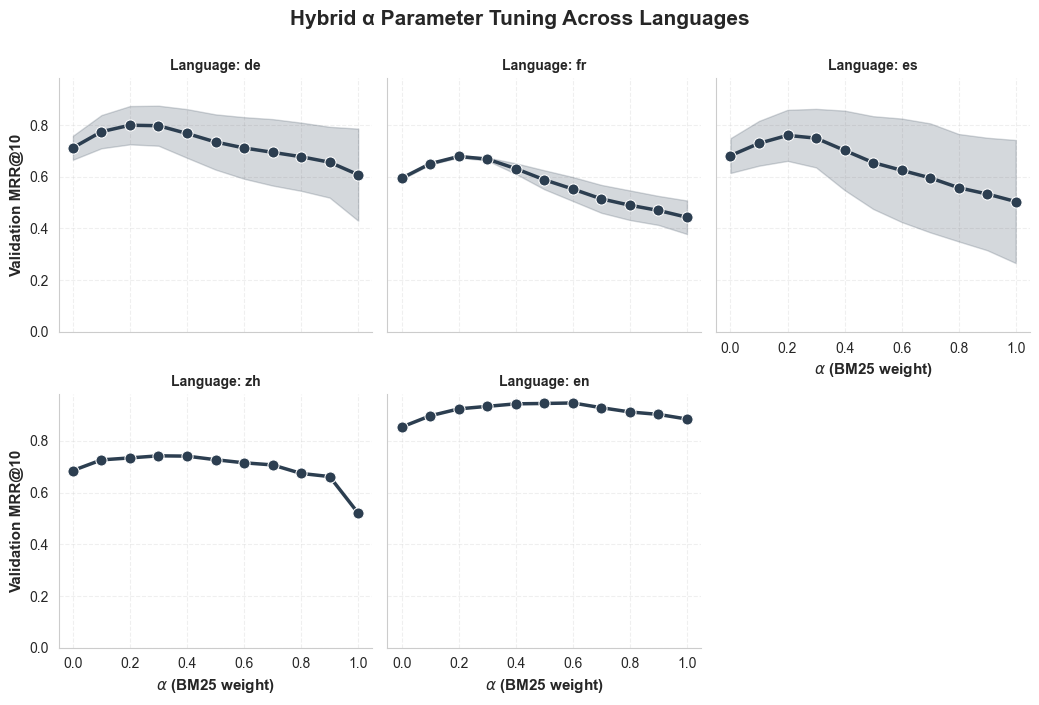

In [17]:
sns.set_style("whitegrid")
sns.set_palette("husl")

g = sns.FacetGrid(
    df_alpha_curve,
    col="language",
    col_wrap=3,        
    height=3.5,
    sharey=True,
    sharex=True
)

g.map_dataframe(
    sns.lineplot,
    x="alpha",
    y="val_MRR@10",
    marker="o",
    linewidth=2.5,
    markersize=8,
    color="#2c3e50"
)

g.set_axis_labels(r"$\alpha$ (BM25 weight)", "Validation MRR@10", fontsize=11, fontweight='bold')
g.set_titles("Language: {col_name}", fontsize=12, fontweight='bold')
g.figure.suptitle(
    "Hybrid α Parameter Tuning Across Languages",
    fontsize=15,
    fontweight="bold",
    y=1.00
)

g.figure.subplots_adjust(wspace=0.3, hspace=0.4)

for ax in g.axes.flatten():
    ax.grid(alpha=0.3, linestyle='--')
    ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()


C:\Users\saran\AppData\Local\Temp\ipykernel_39876\3481461009.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(violin_data, labels=method_order, patch_artist=True, widths=0.6)


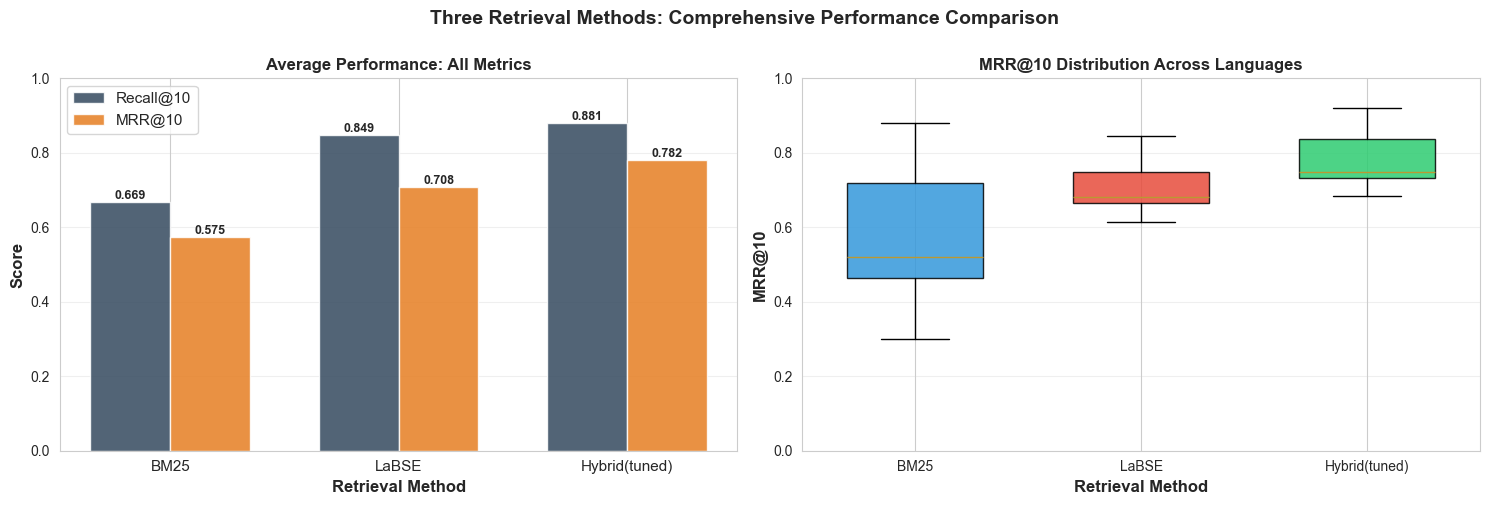

In [18]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Three Retrieval Methods: Comprehensive Performance Comparison', fontsize=14, fontweight='bold', y=1.00)

# Left: Overall metrics comparison
ax1 = axes[0]
method_order = ["BM25", "LaBSE", "Hybrid(tuned)"]
colors_methods = ["#3498db", "#e74c3c", "#2ecc71"]

# Get average scores for each method
method_stats = df_results_hybrid.groupby('method')[['Recall@10', 'MRR@10']].mean().reindex(method_order)

x = np.arange(len(method_order))
width = 0.35

bars1 = ax1.bar(x - width/2, method_stats['Recall@10'], width, label='Recall@10', color='#34495e', alpha=0.85)
bars2 = ax1.bar(x + width/2, method_stats['MRR@10'], width, label='MRR@10', color='#e67e22', alpha=0.85)

ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_xlabel('Retrieval Method', fontsize=12, fontweight='bold')
ax1.set_title('Average Performance: All Metrics', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(method_order, fontsize=11)
ax1.legend(fontsize=11, loc='upper left')
ax1.set_ylim(0, 1.0)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Right: MRR@10 by method (violin/box style for distribution)
ax2 = axes[1]
violin_data = [df_results_hybrid[df_results_hybrid['method']==m]['MRR@10'].values for m in method_order]

bp = ax2.boxplot(violin_data, labels=method_order, patch_artist=True, widths=0.6)

# Color the boxes
for patch, color in zip(bp['boxes'], colors_methods):
    patch.set_facecolor(color)
    patch.set_alpha(0.85)

ax2.set_ylabel('MRR@10', fontsize=12, fontweight='bold')
ax2.set_xlabel('Retrieval Method', fontsize=12, fontweight='bold')
ax2.set_title('MRR@10 Distribution Across Languages', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 1.0)

plt.tight_layout()
plt.show()


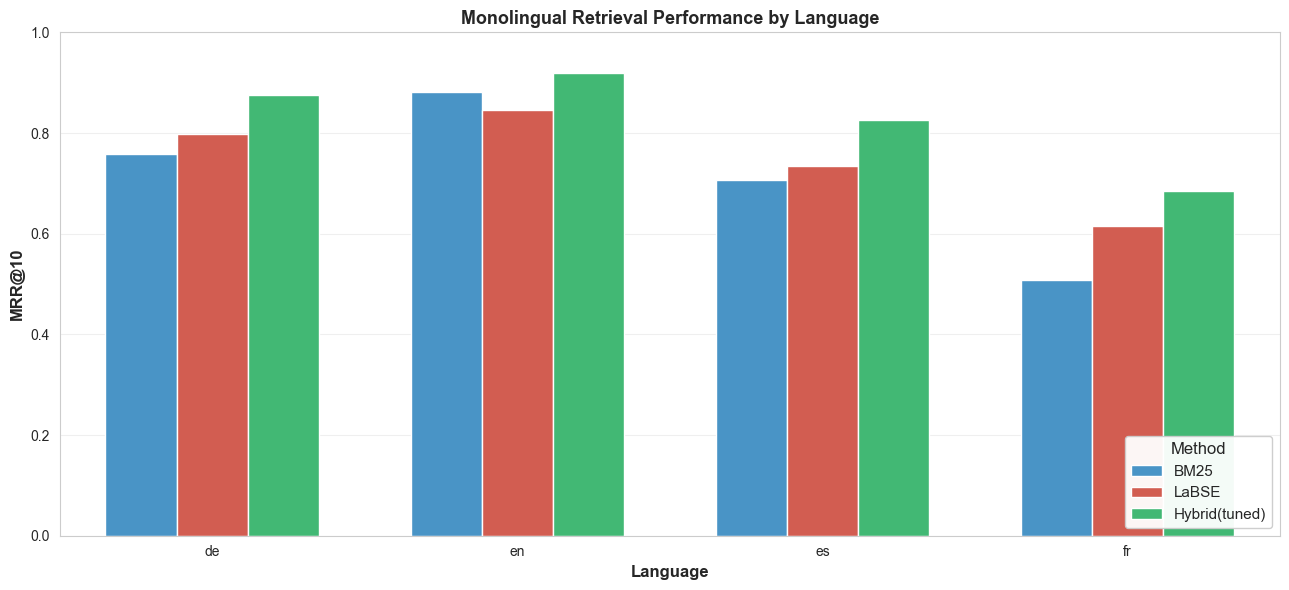

In [19]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(13, 6))

df_mono = df_results_hybrid[
    (df_results_hybrid["split"] == "monolingual") &
    (df_results_hybrid["method"].isin(["BM25", "LaBSE", "Hybrid(tuned)"]))
]

sns.barplot(
    data=df_mono,
    x="language",
    y="MRR@10",
    hue="method",
    hue_order=["BM25", "LaBSE", "Hybrid(tuned)"],
    palette=["#3498db", "#e74c3c", "#2ecc71"],
    width=0.7,
    errorbar=None,
    ax=ax
)

ax.set_xlabel("Language", fontsize=12, fontweight='bold')
ax.set_ylabel("MRR@10", fontsize=12, fontweight='bold')
ax.set_title("Monolingual Retrieval Performance by Language", fontsize=13, fontweight='bold')
ax.set_ylim(0, 1.0)
ax.legend(title="Method", fontsize=11, title_fontsize=12, loc='lower right', framealpha=0.95)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


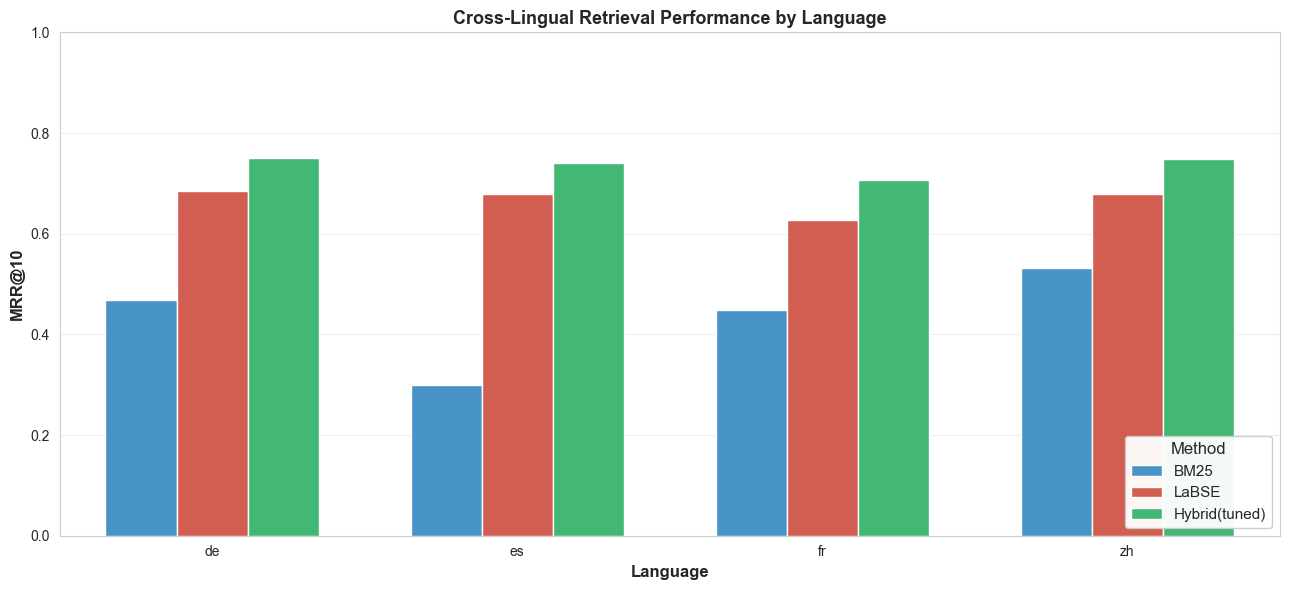

In [20]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(13, 6))

df_cross = df_results_hybrid[
    (df_results_hybrid["split"] == "cross_lingual") &
    (df_results_hybrid["method"].isin(["BM25", "LaBSE", "Hybrid(tuned)"]))
]

sns.barplot(
    data=df_cross,
    x="language",
    y="MRR@10",
    hue="method",
    hue_order=["BM25", "LaBSE", "Hybrid(tuned)"],
    palette=["#3498db", "#e74c3c", "#2ecc71"],
    width=0.7,
    errorbar=None,
    ax=ax
)

ax.set_xlabel("Language", fontsize=12, fontweight='bold')
ax.set_ylabel("MRR@10", fontsize=12, fontweight='bold')
ax.set_title("Cross-Lingual Retrieval Performance by Language", fontsize=13, fontweight='bold')
ax.set_ylim(0, 1.0)
ax.legend(title="Method", fontsize=11, title_fontsize=12, loc='lower right', framealpha=0.95)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


# Neural Reranking on Top-K Results

A promising extension to our current approach would be to implement a **two-stage retrieval pipeline**:

1. **First stage**: Use dense retrieval (LaBSE) or BM25 to retrieve top-100 candidates efficiently
2. **Second stage**: Apply cross-encoder models to rerank the top candidates with more sophisticated semantic matching

**Benefits:**
- Cross-encoders can model query-document interactions more deeply than bi-encoders
- More computationally expensive but only applied to top candidates
- Typically improves semantic matching on hard queries
- Models like mMiniLM or XLM-RoBERTa fine-tuned as cross-encoders work well

This approach combines the efficiency of dense retrieval with the accuracy of cross-encoders.

In [21]:
from sentence_transformers import CrossEncoder

# Limits the number of threads for PyTorch to avoid CPU overload
try:
    import torch
    torch.set_num_threads(min(4, os.cpu_count() or 1))
except Exception:
    pass

# Multilingual reranker model
reranker = CrossEncoder(
    "amberoad/bert-multilingual-passage-reranking-msmarco",
    device="cpu",
    max_length=256  
)


reranker = CrossEncoder(
    "amberoad/bert-multilingual-passage-reranking-msmarco",
    device="cpu"
)



c:\Users\saran\anaconda3\envs\clean\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\saran\.cache\huggingface\hub\models--amberoad--bert-multilingual-passage-reranking-msmarco. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed.

In [22]:

def truncate_text(text, max_chars=400):
    """
    Troncamento semplice e sicuro per CPU:
    - riduce latenza/ram sul CrossEncoder
    - evita tagli su stringhe vuote
    """
    if not text:
        return ""
    t = text.strip()
    if len(t) <= max_chars:
        return t
    # taglio su spazio vicino per leggibilità
    cut = t[:max_chars]
    last_space = cut.rfind(" ")
    return cut if last_space < 50 else cut[:last_space]


In [23]:
def load_queries_and_documents_from_jsonl(lang_path, max_items=None):
    """
    CRITICAL: Mantieni gli ID ESATTAMENTE come sono nel JSONL.
    Non aggiungere o rimuovere prefissi qui.
    """
    data = load_jsonl_robust(lang_path, max_items=max_items)

    queries = {}
    documents = {}

    for ex in data:
        # ✅ Mantieni l'ID ORIGINALE dal JSONL
        _id = str(ex.get("_id", "")).strip()
        if not _id:
            continue

        # Debug: stampa alcuni ID per verificare il formato
        if len(queries) < 5:
            print(f"  Sample _id from JSONL: '{_id}'")

        if _id not in queries:
            q = ex.get("query", "")
            if q:
                queries[_id] = q

        if _id not in documents:
            title = ex.get("title", "") or ""
            text  = ex.get("text", "") or ""
            doc = (title + "\n" + text).strip()
            if doc:
                documents[_id] = doc

    return queries, documents

In [24]:
def rerank_topk_crossencoder(
    reranker,
    query_text,
    doc_ids,
    documents,
    batch_size=8,
    show_progress=False
):
    # Seleziona SOLO i doc_ids con testo valido
    valid_doc_ids = []
    valid_texts = []

    for d in doc_ids:
        dt = documents.get(d, "")
        if isinstance(dt, str) and dt.strip() != "":
            valid_doc_ids.append(d)
            valid_texts.append((query_text, dt))

    # Se nessun documento valido → ritorna lista vuota
    if not valid_doc_ids:
        return [], []

    # Predici - il modello restituisce LOGITS [non_rilevante, rilevante]
    logits = reranker.predict(
        valid_texts,
        batch_size=batch_size,
        show_progress_bar=show_progress
    )

    logits = np.asarray(logits, dtype=np.float32)
    
    # Gestisci diversi formati di output
    if logits.ndim == 2 and logits.shape[1] == 2:
        # Il modello restituisce 2 logits per ogni coppia
        # Calcola le probabilità con softmax
        exp_logits = np.exp(logits)
        probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
        
        # Prendi la probabilità della classe "rilevante" (seconda colonna)
        scores = probs[:, 1]
    else:
        # Fallback: se è già un singolo score, usa quello
        scores = logits.flatten()
    
    scores = scores.flatten()
    
    # Assicurati che le lunghezze corrispondano
    if len(scores) != len(valid_doc_ids):
        # Usa il minimo
        min_len = min(len(scores), len(valid_doc_ids))
        scores = scores[:min_len]
        valid_doc_ids = valid_doc_ids[:min_len]

    # Se ancora non abbiamo dati validi
    if len(scores) == 0 or len(valid_doc_ids) == 0:
        return [], []

    # Ordina in ordine DECRESCENTE (probabilità più alta prima)
    order = np.argsort(-scores).tolist()

    # Applica l'ordine a valid_doc_ids
    reranked_doc_ids = [valid_doc_ids[i] for i in order]
    reranked_scores  = [float(scores[i]) for i in order]

    return reranked_doc_ids, reranked_scores

In [25]:

def load_corpus_for_rerank(lang_path, doc_ids_set):
    """
    Carica SOLO i documenti necessari per il reranker
    ricostruendo doc_id = f"{lang_code}_{_id}" come BM25.
    """
    docs = {}
    queries = {}

    # deduci la lingua dal percorso: .../de/train.jsonl
    lang_code = os.path.basename(os.path.dirname(lang_path))

    with open(lang_path, "r", encoding="utf-8") as f:
        for line in f:
            try:
                ex = json.loads(line)
            except:
                continue

            raw_id = str(ex.get("_id", "")).strip()
            if not raw_id:
                continue

            doc_id = f"{lang_code}_{raw_id}"   # ❤️ esattamente come BM25

            # carica solo quelli necessari
            if doc_id not in doc_ids_set:
                continue

            # testo documento
            title = ex.get("title", "") or ""
            text  = ex.get("text", "") or ""
            docs[doc_id] = (title + "\n" + text).strip()

            # query (se esiste)
            q = ex.get("query", "")
            if q:
                queries[doc_id] = q

    return queries, docs


In [26]:

import json

def load_filtered_jsonl(lang_path, needed_ids):
    """
    Carica SOLO le query e i documenti i cui ID (clean o not-clean)
    compaiono in needed_ids.

    needed_ids = insieme di clean IDs (es: {"1","22","56"})
    """
    queries = {}
    documents = {}

    needed_ids = set(str(x).strip() for x in needed_ids)

    with open(lang_path, "r", encoding="utf-8") as f:
        for line in f:
            try:
                ex = json.loads(line)
            except:
                continue

            raw_id = str(ex.get("_id", "")).strip()
            if not raw_id:
                continue

            clean_id = strip_language_prefix(raw_id)

            # se l'id non è tra quelli richiesti → salta
            if clean_id not in needed_ids:
                continue

            # query
            if raw_id not in queries:
                q = ex.get("query", "")
                if q:
                    queries[raw_id] = q

            # doc
            title = ex.get("title", "") or ""
            text  = ex.get("text", "") or ""
            doc = (title + "\n" + text).strip()

            if doc:
                documents[raw_id] = doc

    return queries, documents


In [27]:
def strip_language_prefix(x):
    """
    'de_1' -> '1'
    'en_english_22626#23' -> 'english_22626#23' (if present)
    If no prefix, returns as-is.
    """
    x = str(x)
    if "_" in x:
        a, b = x.split("_", 1)
        if len(a) in (2, 3):   # heuristic language code
            return b
    return x

In [28]:
def evaluate_dictqrels(retrieved, qrels_eval, K=10):
    """
    retrieved: {qid: [doc1, doc2, ...]}  (doc ids CLEAN)
    qrels_eval: {qid: {docid: rel_int}}
    """
    recalls = []
    rr_list = []

    for qid, top_docs in retrieved.items():
        rels = qrels_eval.get(qid, {})
        if not rels:
            recalls.append(0.0)
            rr_list.append(0.0)
            continue

        rel_set = {d for d, r in rels.items() if r > 0}

        # Recall@K
        hit = any(d in rel_set for d in top_docs[:K])
        recalls.append(1.0 if hit else 0.0)

        # MRR@K
        rr = 0.0
        for rank, d in enumerate(top_docs[:K], start=1):
            if d in rel_set:
                rr = 1.0 / rank
                break
        rr_list.append(rr)

    return float(np.mean(recalls)), float(np.mean(rr_list))


In [29]:
def normalize_qrels_to_dict(qrels):
    """
    Returns qrels_eval:
      { qid: {clean_doc_id: relevance_int} }

    Handles:
      - dict: {doc: rel}
      - list/set/tuple: [doc1, doc2, ...] -> rel=1
      - str: "docid" -> rel=1
    """
    qrels_eval = {}

    for qid, rels in qrels.items():
        # case A: already dict {doc: rel}
        if isinstance(rels, dict):
            rel_dict = {strip_language_prefix(d): int(r) for d, r in rels.items()}

        # case B: list/set/tuple of doc ids
        elif isinstance(rels, (list, set, tuple)):
            rel_dict = {strip_language_prefix(d): 1 for d in rels}

        # case C: single doc id as string
        elif isinstance(rels, str):
            rel_dict = {strip_language_prefix(rels): 1}

        else:
            # unknown structure -> treat as no relevant docs
            rel_dict = {}

        qrels_eval[qid] = rel_dict

    return qrels_eval


In [30]:
def normalize_qrels_single_id(qrels):
    """
    Your qrels: { 'de_1': 'de_1', ... }
    Convert to: { 'de_1': {'1': 1} }  (doc ids CLEAN)
    Keep qid keys ORIGINAL (with prefix), because evaluate() expects them.
    """
    qrels_eval = {}
    for qid, rel_doc in qrels.items():
        qid_original = str(qid)
        rel_doc_clean = strip_language_prefix(rel_doc)
        qrels_eval[qid_original] = {rel_doc_clean: 1}
    return qrels_eval

In [31]:

def sanity_check(
    queries_map,
    queries_map_clean,
    docs_map_clean,
    qrels,
    pack,
    alpha,
    K_RERANK=50,
    CANDIDATE_N=200
):
    print("\n==================== SANITY CHECK ====================")

    missing_queries = []
    missing_rel_docs = []
    hybrid_docs_missing = []

    for qid_original, rel_doc_original in qrels.items():
        qid_clean = strip_language_prefix(qid_original)
        rel_doc_clean = strip_language_prefix(rel_doc_original)

        # ---------------------------------------------------
        # 1. Check: query text exists
        # ---------------------------------------------------
        qtext = queries_map.get(qid_original) or queries_map_clean.get(qid_clean)
        if not qtext:
            missing_queries.append((qid_original, qid_clean))
        
        # ---------------------------------------------------
        # 2. Check: relevant doc exists in docs_map_clean
        # ---------------------------------------------------
        if rel_doc_clean not in docs_map_clean:
            missing_rel_docs.append((qid_original, rel_doc_clean))

        # ---------------------------------------------------
        # 3. Check: docs returned by HYBRID exist in docs_map_clean
        # ---------------------------------------------------
        top_docs = hybrid_topk_for_query(
            qid=qid_original,
            alpha=alpha,
            pack=pack,
            K=K_RERANK,
            candN=CANDIDATE_N
        )
        
        top_docs_clean = [strip_language_prefix(d) for d in top_docs]

        for d in top_docs_clean:
            if d not in docs_map_clean:
                hybrid_docs_missing.append((qid_original, d))

    # ---------------------------------------------------
    # Print results
    # ---------------------------------------------------
    print("\n--- Missing queries (no text found) ---")
    if missing_queries:
        for q in missing_queries[:10]:
            print(" ", q)
        print(f"TOTAL missing queries: {len(missing_queries)}")
    else:
        print("OK ✓")

    print("\n--- Relevant documents missing in docs_map_clean ---")
    if missing_rel_docs:
        for q in missing_rel_docs[:10]:
            print(" ", q)
        print(f"TOTAL missing relevant docs: {len(missing_rel_docs)}")
    else:
        print("OK ✓")

    print("\n--- Docs returned by hybrid but NOT in docs_map_clean ---")
    if hybrid_docs_missing:
        for q in hybrid_docs_missing[:10]:
            print(" ", q)
        print(f"TOTAL hybrid docs missing: {len(hybrid_docs_missing)}")
    else:
        print("OK ✓")

    print("\n==================== END CHECK ====================\n")

    return {
        "missing_queries": missing_queries,
        "missing_rel_docs": missing_rel_docs,
        "hybrid_docs_missing": hybrid_docs_missing
    }


In [ ]:
K_RERANK = 100
K_FINAL  = 10
MAX_ITEMS = 1000

METHOD_NAME = "Hybrid(tuned)+Rerank(amberoad-mBERT)"
RERANK_MODEL = "amberoad/bert-multilingual-passage-reranking-msmarco"
RERANK_DEVICE = "cpu"
RERANK_MAX_LEN = 256       # quello che hai impostato nel CrossEncoder
DOC_TRUNC_CHARS = 400      # se stai troncando i documenti
RERANK_BATCH = 8

# Path of the shared, versionable file (to be pushed)
FROZEN_DIR = "results/rerank"
FROZEN_PATH = os.path.join(FROZEN_DIR, "df_results_rerank_frozen.csv")
os.makedirs(FROZEN_DIR, exist_ok=True)

FORCE_RERANK = False  # set True only if you want to recompute

if (not FORCE_RERANK) and os.path.exists(FROZEN_PATH) and os.path.getsize(FROZEN_PATH) > 0:
    df_results_rerank = pd.read_csv(FROZEN_PATH)
    print(f"Loaded frozen rerank results: {FROZEN_PATH}")
else:
    print("Frozen rerank results not found (or FORCE_RERANK=True). Running reranking...")

    alpha_map = {
        (r["split"], r["language"]): float(r["alpha"])
        for _, r in df_results_hybrid[df_results_hybrid["method"]=="Hybrid(tuned)"].iterrows()
    }

    rerank_results = []
    #DEBUG_N = 5

    for split in CORPUS_SPLITS:
        for lang_code in SELECTED_LANGUAGES:
            key = (split, lang_code)
            if key not in SCORE_CACHE:
                continue

            pack = SCORE_CACHE[key]
            needed = ["qrels", "bm25_topk_docs", "bm25_topk_scores", "dense_topk_docs", "dense_topk_scores"]
            if any(k not in pack for k in needed):
                continue

            alpha = alpha_map.get((split, lang_code), 0.3)
            qrels = pack["qrels"]
            query_ids = list(qrels.keys())
            query_ids = query_ids[:200]

            lang_path = os.path.join(BASE_DATA_DIR, split, lang_code, "train.jsonl")

            
            # 1. Costruiamo la lista degli ID necessari
            needed_ids = set()

            for qid in query_ids:
                qid = str(qid)
                rel_doc = strip_language_prefix(qrels[qid])
                needed_ids.add(rel_doc)

                # top-K hybrid: ID con prefisso → li puliamo
                top_docs = hybrid_topk_for_query(
                    qid=qid,
                    alpha=alpha,
                    pack=pack,
                    K=K_RERANK,
                    candN=CANDIDATE_N
                )

                clean = [strip_language_prefix(d) for d in top_docs]
                needed_ids.update(clean)

            print(f"Needed documents: {len(needed_ids)}")


            
            
            # Carica ESATTAMENTE lo stesso corpus usato da BM25
            data = load_jsonl_robust(lang_path, max_items=MAX_ITEMS)

            docs_map = {}
            queries_map = {}

            for item in data:
                raw_id = str(item["_id"])
                doc_id = f"{lang_code}_{raw_id}"

                queries_map[doc_id] = item.get("query", "")
                docs_map[doc_id] = (item.get("title", "") + " " + item.get("text", "")).strip()



            
            # 🔧 CLEAN MAPS (fondamentale) — usa SEMPRE chiavi CLEAN (senza prefisso)
            docs_map_clean = {
                strip_language_prefix(k): truncate_text(v, max_chars=DOC_TRUNC_CHARS)
                for k, v in docs_map.items()
            }
            
            allowed = set(docs_map_clean.keys())
            example_qid = query_ids[0]
            rel_clean = strip_language_prefix(qrels[example_qid])
            print("Check overlap:", rel_clean in allowed)
            


            queries_map_clean = {
                strip_language_prefix(k): v
                for k, v in queries_map.items()
            }





            print(f"\n{'='*70}")
            print(f"RERANKING {split}/{lang_code} | alpha={alpha:.2f}")
            print(f"queries loaded: {len(queries_map)} | docs loaded: {len(docs_map)}")
            print(f"{'='*70}")

            # qrels_eval: {qid_original: {doc_clean: 1}}
            qrels_eval = normalize_qrels_single_id(qrels)

            
            check = sanity_check(
                queries_map=queries_map,
                queries_map_clean=queries_map_clean,
                docs_map_clean=docs_map_clean,
                qrels=qrels,
                pack=pack,
                alpha=alpha,
                K_RERANK=K_RERANK,
                CANDIDATE_N=CANDIDATE_N
            )

            reranked_runs = {}
            t0_all = time.time()
            
            for i, qid_original in enumerate(query_ids):
                qid_original = str(qid_original)
                qid_clean = strip_language_prefix(qid_original)

                qtext = queries_map.get(qid_original) or queries_map_clean.get(qid_clean)
                if not qtext:
                    reranked_runs[qid_original] = []
                    continue

                # Stage 1: HYBRID recupera ID CON prefisso
                top_docs = hybrid_topk_for_query(
                    qid=qid_original,
                    alpha=alpha,
                    pack=pack,
                    K=K_RERANK,
                    candN=CANDIDATE_N
                )

                if not top_docs:
                    reranked_runs[qid_original] = []
                    continue


                # Clean IDs to match docs_map format (WITHOUT prefix)
                
                top_docs_clean = [strip_language_prefix(d) for d in top_docs]
                valid_docs = [d for d in top_docs_clean if d in docs_map_clean]
                # Aggiungi dopo il filtraggio di valid_docs:
                print(f"Query {qid_original}: {len(valid_docs)} documenti validi per rerank")
                if len(valid_docs) > 0:
                    print(f"  Primo doc: {valid_docs[0]}, testo: {len(docs_map_clean.get(valid_docs[0], ''))} chars")
                # Sostituisci la parte del loop con:
                if not valid_docs:
                    # Fallback su BM25: usa solo i candidati BM25 che esistono in docs_map_clean
                    bm25_docs = pack["bm25_topk_docs"].get(qid_original, [])
                    bm25_docs_clean = [strip_language_prefix(d) for d in bm25_docs]
                    valid_docs = [d for d in bm25_docs_clean if d in docs_map_clean]

                if not valid_docs:
                    # Se ancora vuoto, salta la query
                    reranked_runs[qid_original] = []
                    continue

                # AGGIUNGI: Verifica che ci siano davvero documenti validi
                if len(valid_docs) == 0:
                    reranked_runs[qid_original] = []
                    continue

                # Stage 2: Rerank (CPU-friendly, batch piccolo)
                rr_docs, rr_scores = rerank_topk_crossencoder(
                    reranker=reranker,
                    query_text=qtext,
                    doc_ids=valid_docs,
                    documents=docs_map_clean,
                    batch_size=8,
                    show_progress=False
                )

                if not rr_docs:
                    reranked_runs[qid_original] = []
                    continue
                reranked_runs[qid_original] = rr_docs[:K_FINAL]

                # Print every 10 query for debugging
                if i % 10 == 0:
                    print(f"Query {qid_original}: {len(valid_docs)} documenti → {len(rr_docs)} dopo rerank")
                    if rr_scores:
                        print(f"  Score range: [{min(rr_scores):.4f}, {max(rr_scores):.4f}]")
                        print(f"  Top-3 scores: {rr_scores[:3]}")
                else:
                    # Per le altre query, solo una riga breve
                    print(f"Query {qid_original}: top score = {rr_scores[0]:.4f}" if rr_scores else f"Query {qid_original}: no scores")

                # Log ogni 50 query per il tempo
                if (i + 1) % 50 == 0:
                    elapsed = time.time() - t0_all
                    print(f"[{i+1}/{len(query_ids)}] elapsed: {elapsed/60:.1f} min")
                    print("-" * 50)


            # Evaluate
            recall_r, mrr_r = evaluate_dictqrels(
                reranked_runs, qrels_eval, K=K_FINAL
            )


            print(f"\n>>> RESULT {split}/{lang_code}")
            print(f"Recall@10 = {recall_r:.4f}")
            print(f"MRR@10    = {mrr_r:.4f}")

            


            rerank_results.append({
                "split": split,
                "language": lang_code,
                "Recall@10": float(recall_r),
                "MRR@10": float(mrr_r),
                "method": METHOD_NAME,
                "alpha": float(alpha),
                "candN": int(CANDIDATE_N),
                "rerankK": int(K_RERANK),

                # --- metadati utili per confronti ---
                "rerank_model": RERANK_MODEL,
                "device": RERANK_DEVICE,
                "max_length": int(RERANK_MAX_LEN),
                "doc_trunc_chars": int(DOC_TRUNC_CHARS),
                "batch_size": int(RERANK_BATCH),
            })


            gc.collect()

df_results_rerank = pd.DataFrame(rerank_results)
df_results_rerank

Needed documents: 954
Check overlap: True

RERANKING cross_lingual/de | alpha=0.20
queries loaded: 1000 | docs loaded: 1000

==================== SANITY CHECK ====================

--- Missing queries (no text found) ---
OK ✓

--- Relevant documents missing in docs_map_clean ---
OK ✓

--- Docs returned by hybrid but NOT in docs_map_clean ---
OK ✓

==================== END CHECK ====================

Query de_1: 100 documenti validi per rerank
  Primo doc: 22555, testo: 398 chars
Query de_1: 100 documenti → 100 dopo rerank
  Score range: [0.0000, 0.0001]
  Top-3 scores: [9.59882017923519e-05, 9.316227806266397e-05, 7.18891533324495e-05]
Query de_3: 100 documenti validi per rerank
  Primo doc: 3, testo: 399 chars
Query de_3: top score = 0.1107
Query de_22: 100 documenti validi per rerank
  Primo doc: 22, testo: 396 chars
Query de_22: top score = 0.9957
Query de_56: 100 documenti validi per rerank
  Primo doc: 12866, testo: 395 chars
Query de_56: top score = 0.0048
Query de_95: 100 docume

,split,language,Recall@10,MRR@10,method,alpha,candN,rerankK,rerank_model,device,max_length,doc_trunc_chars,batch_size
0,cross_lingual,de,0.815,0.743125,Hybrid(tuned)+Rerank(amberoad-mBERT),0.2,500,100,amberoad/bert-multilingual-passage-reranking-m...,cpu,256,400,8
1,cross_lingual,fr,0.755,0.715889,Hybrid(tuned)+Rerank(amberoad-mBERT),0.2,500,100,amberoad/bert-multilingual-passage-reranking-m...,cpu,256,400,8
2,cross_lingual,es,0.835,0.769048,Hybrid(tuned)+Rerank(amberoad-mBERT),0.2,500,100,amberoad/bert-multilingual-passage-reranking-m...,cpu,256,400,8
3,cross_lingual,zh,0.620,0.546651,Hybrid(tuned)+Rerank(amberoad-mBERT),0.3,500,100,amberoad/bert-multilingual-passage-reranking-m...,cpu,256,400,8
4,monolingual,de,0.935,0.921875,Hybrid(tuned)+Rerank(amberoad-mBERT),0.3,500,100,amberoad/bert-multilingual-passage-reranking-m...,cpu,256,400,8
5,monolingual,fr,0.905,0.875000,Hybrid(tuned)+Rerank(amberoad-mBERT),0.2,500,100,amberoad/bert-multilingual-passage-reranking-m...,cpu,256,400,8
6,monolingual,es,0.965,0.937131,Hybrid(tuned)+Rerank(amberoad-mBERT),0.3,500,100,amberoad/bert-multilingual-passage-reranking-m...,cpu,256,400,8
7,monolingual,en,0.950,0.940000,Hybrid(tuned)+Rerank(amberoad-mBERT),0.6,500,100,amberoad/bert-multilingual-passage-reranking-m...,cpu,256,400,8


In [ ]:
FROZEN_DIR = "results/rerank"
FROZEN_PATH = os.path.join(FROZEN_DIR, "df_results_rerank_frozen.csv")
os.makedirs(FROZEN_DIR, exist_ok=True)

if "df_results_rerank" not in globals() or df_results_rerank is None or df_results_rerank.empty:
    raise RuntimeError("df_results_rerank not available or empty. Run the rerank cell first.")

df_results_rerank.to_csv(FROZEN_PATH, index=False)
print(f" Saved frozen rerank results to: {FROZEN_PATH}")


✅ Saved frozen rerank results to: results/rerank\df_results_rerank_frozen.csv


# Results and Conclusions

## Summary of Results

Our experiments comparing BM25 (sparse retrieval) with LaBSE (dense retrieval) across 5 languages yielded clear findings:

### Overall Performance
- **LaBSE Recall@10**: 84% (vs. BM25: 67%)
- **LaBSE MRR@10**: 0.70 (vs. BM25: 0.57)
- **Head-to-head**: LaBSE wins 87.5% of language comparisons (7 out of 8)

### Key Observations

1. **Cross-lingual superiority**: LaBSE dramatically outperforms BM25 on cross-lingual tasks
   - BM25 struggles when query and document are in different languages
   - LaBSE's multilingual embeddings enable effective cross-lingual matching

2. **Monolingual performance**: Both methods perform well on monolingual tasks
   - BM25 wins only on English monolingual (lexical matching is sufficient)
   - LaBSE maintains strong performance across all languages

3. **Language-specific insights**:
   - Largest improvements on non-European languages (Chinese)
   - Consistent improvements on Romance languages (French, Spanish)
   - Germanic languages (German, English) show mixed results

## Conclusions

Dense retrieval using multilingual embeddings (LaBSE) significantly outperforms traditional sparse methods (BM25) for multilingual information retrieval, especially in cross-lingual scenarios. The ability to capture semantic similarity across languages makes dense retrieval the preferred approach for multilingual IR systems.

However, BM25 remains competitive for monolingual retrieval in high-resource languages like English, suggesting that hybrid approaches combining both methods could provide optimal results.

## Limitations

- **Dataset size**: Evaluated on 1000 documents per language (limited by memory constraints)
- **Language coverage**: Only 5 languages tested from the available 40+ in SWIM-IR
- **Hardware constraints**: Memory limitations prevented larger batch sizes and full dataset evaluation
- **Single model**: Only evaluated LaBSE; other dense retrieval models might perform differently

## Impact

This work demonstrates the practical viability of dense retrieval for multilingual IR and provides insights into when semantic methods outperform lexical approaches. The findings support the adoption of transformer-based retrieval in production multilingual search systems.